In [57]:
import os
import numpy as np
import glob
import PIL.Image as Image
import cv2
# pip install torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
from omegaconf import OmegaConf
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [58]:
config = OmegaConf.create({
    'img_size': 512, # org size mean 575 x 766
    'batch_size': 2, #6
    'seed': 42,
    'workers': 0, #3
    'lr': 1e-4,
    'epochs': 50,#50
    'loss': 'WeightedBCE', # BCE, WeightedBCE
    'set_seed': True,
    'device': 'cpu',
    'model': 'EncDec', #EncDec, SimpleUNET
    'use_wandb': True,
    'tag': 'REAL',
    'pos_total': None,
    'neg_total': None,
}) 

model_path = 'dtu_dlcv/r3v8q8oh/checkpoints/epoch=28-test_acc=0.00.ckpt'

In [40]:
# class PhC(torch.utils.data.Dataset):
#     def __init__(self,transform):
#         'Initialization'
#         self.transform = transform
#         self.data_path = "/dtu/datasets1/02516/PH2_Dataset_images"
#         self.image_paths = sorted(glob.glob(f"{self.data_path}/*/*_Dermoscopic_Image/*.bmp"))
#         self.label_paths = sorted(glob.glob(f"{self.data_path}/*/*_lesion/*_lesion.bmp"))
#         # self.train_idx,val_test_idx = train_test_split(list(range(len(self.image_paths))),train_size=0.6,random_state=config.seed)
#         # self.val_idx, self.test_idx = train_test_split(val_test_idx,train_size=0.5,random_state=config.seed)
        
#     def __len__(self):
#         'Returns the total number of samples'
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         'Generates one sample of data'
#         image_path = self.image_paths[idx]
#         label_path = self.label_paths[idx]
        
#         # if idx in self.train_idx:
#         #     label = 'train'
#         # elif idx in self.val_idx:
#         #     label = 'val'
#         # elif idx in self.test_idx:
#         #     label = 'test'
#         image = Image.open(image_path)
#         label = Image.open(label_path)
#         Y = self.transform(label)
#         X = self.transform(image)

#         return X, Y
    

# size = config.img_size
# train_transform = transforms.Compose([transforms.Resize((size, size)), 
#                                     transforms.ToTensor()])
# test_transform = transforms.Compose([transforms.Resize((size, size)), 
#                                     transforms.ToTensor()])

# trainset = PhC(transform=train_transform)
# testset, val_test_set = torch.utils.data.random_split(trainset, [120, 80],generator=torch.Generator().manual_seed(config.seed))
# valset = PhC(transform=test_transform)
# testset = PhC(transform=test_transform)

# train_loader = DataLoader(trainset, batch_size=config.batch_size, shuffle=True, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))
# val_loader = DataLoader(valset, batch_size=config.batch_size, shuffle=False, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))
# test_loader = DataLoader(testset, batch_size=config.batch_size, shuffle=False, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))

In [59]:
#############
#DELETE
os.chdir('/Users/andreastheilgaard/Desktop/deep-learning-in-computer-vison/')
#############

In [60]:
class DRIVE(torch.utils.data.Dataset):
    def __init__(self,transform,idx_list):
        'Initialization'
        self.transform = transform
        self.data_path = "dtu/datasets1/02516/DRIVE/training"
        self.image_paths = np.array(sorted(glob.glob(f"{self.data_path}/images/*.tif")))[idx_list]
        self.label_paths = np.array(sorted(glob.glob(f"{self.data_path}/1st_manual/*.gif")))[idx_list]

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = np.array(Image.open(image_path),dtype=np.float32)/255
        label = np.array(Image.open(label_path),dtype=np.float32)/255

        augmented_data = self.transform(image=image,mask=label)
        X,Y =augmented_data['image'],augmented_data['mask'].unsqueeze(0)
        return X,Y
    
def get_data():
    size = config.img_size
    train_transform = A.Compose([
                            A.Resize(size,size),
                            A.VerticalFlip(p=0.3), # 0.3
                            #A.HorizontalFlip(p=1.0),
                            #A.Rotate(p=1.0,limit=45),
                            ToTensorV2()
                        ], is_check_shapes=False) 

    val_test_transform = A.Compose([
                            A.Resize(size,size),
                            ToTensorV2()
                        ], is_check_shapes=False) 

    data_path = "dtu/datasets1/02516/DRIVE/training"
    image_paths = sorted(glob.glob(f"{data_path}/images/*.tif"))
    train_idx,val_test_idx = train_test_split(list(range(len(image_paths))),train_size=0.6,random_state=config.seed)
    val_idx,test_idx = train_test_split(val_test_idx,train_size=0.5,random_state=42)
    trainset = DRIVE(transform=train_transform,idx_list=train_idx)
    valset = DRIVE(transform=val_test_transform,idx_list=val_idx)
    testset = DRIVE(transform=val_test_transform,idx_list=test_idx)
    train_loader = DataLoader(trainset, batch_size=config.batch_size, shuffle=True, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))
    val_loader = DataLoader(valset, batch_size=config.batch_size, shuffle=False, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))
    test_loader = DataLoader(testset, batch_size=config.batch_size, shuffle=False, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))

    config.pos_total = sum([batch[1].sum().item() for batch in train_loader])
    config.neg_total = sum([(batch[1]==0).sum().item() for batch in train_loader])
    return train_loader,val_loader,test_loader
train_loader,val_loader,test_loader = get_data()

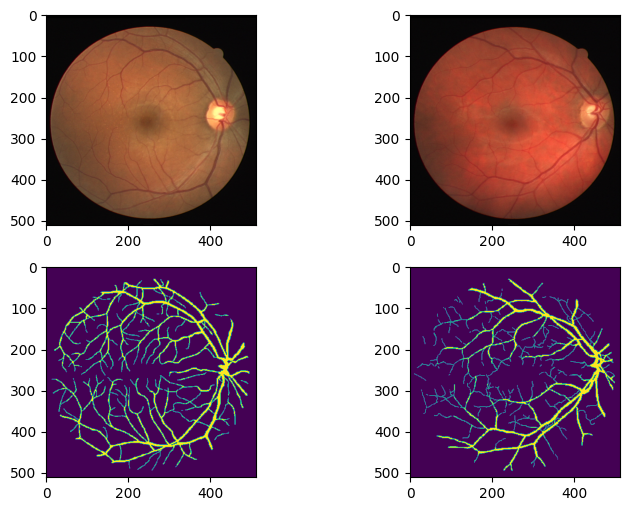

In [61]:
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))
val_images, val_labels = next(iter(val_loader))

plt.rcParams['figure.figsize'] = [18, 6]

for i in range(2):
    plt.subplot(2, 4, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(val_images[i], 0, 2), 0, 1))

    plt.subplot(2, 4, i+5)
    plt.imshow(val_labels[i].squeeze())
plt.show()

In [62]:
class metrics:
    def __init__(self,eps:float=1e-8):
        self.eps = eps

    def get_confusion(self,y_hat,mask):
        # assuming y_hat is logits, then convert to confidences using sigmoid
        if y_hat.min().item() < 0.0 or (y_hat.max().item() > 1.0):
            y_hat = torch.sigmoid(y_hat)
        y_hat = (y_hat > 0.50).float()

        self.TP = (y_hat.flatten() * mask.flatten()).sum()
        self.FN = mask[y_hat == 0].sum()
        self.FP = y_hat[mask == 0].sum()
        self.TN = y_hat.numel() - self.TP - self.FN - self.FP

    def get_metrics(self,y_hat,mask):
        self.get_confusion(y_hat,mask)
        dice = ((2 * self.TP) / (2 * self.TP + self.FN + self.FP + self.eps)).item()
        iou = ((self.TP) / (self.TP + self.FN + self.FP )).item()
        acc = (self.TP+self.TN)/(self.TP+self.TN+self.FP+self.FN)
        sensitivity = self.TP/(self.TP+self.FN)
        specificity = self.TN/(self.TN+self.FP)
        self.metric_dict = {'dice':dice,'iou':iou,'acc':acc,'sensitivity':sensitivity,'specificity':specificity}
        return self.metric_dict 
    
    def print_my_metrics(self,y_hat,mask,type_):
        metric_dict = self.get_metrics(y_hat,mask)
        for key in metric_dict:
            print(f"{type_} {key}: {metric_dict[key]}")
    
evaluator = metrics() 

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## SAM Automatic masking

In [64]:
sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
# device = "cuda"
sam = (sam_model_registry[model_type](checkpoint=sam_checkpoint)).to(device)
mask_generator = SamAutomaticMaskGenerator(sam)

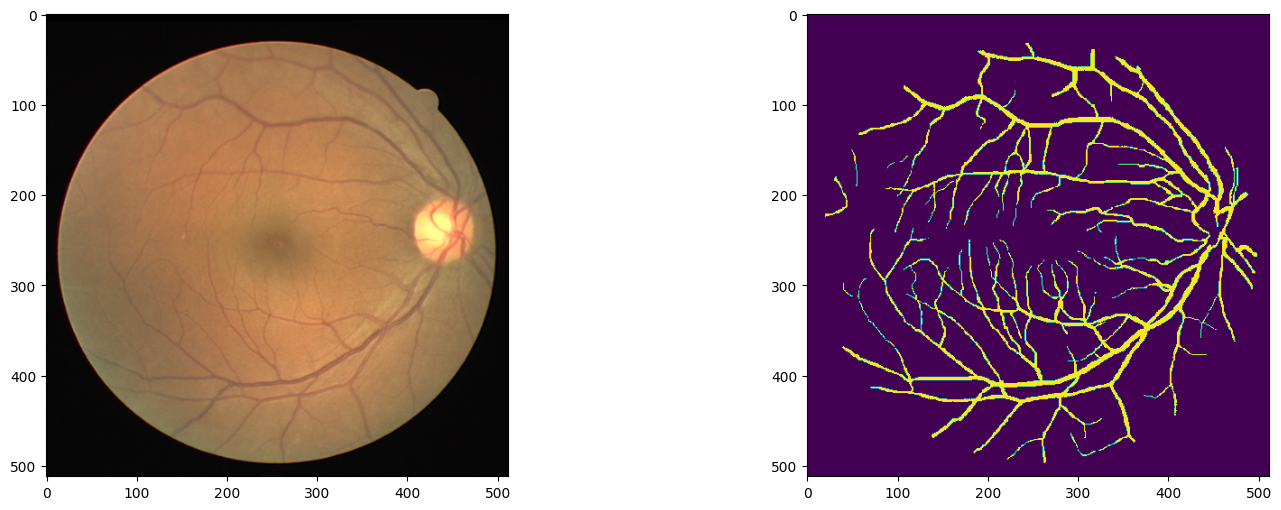

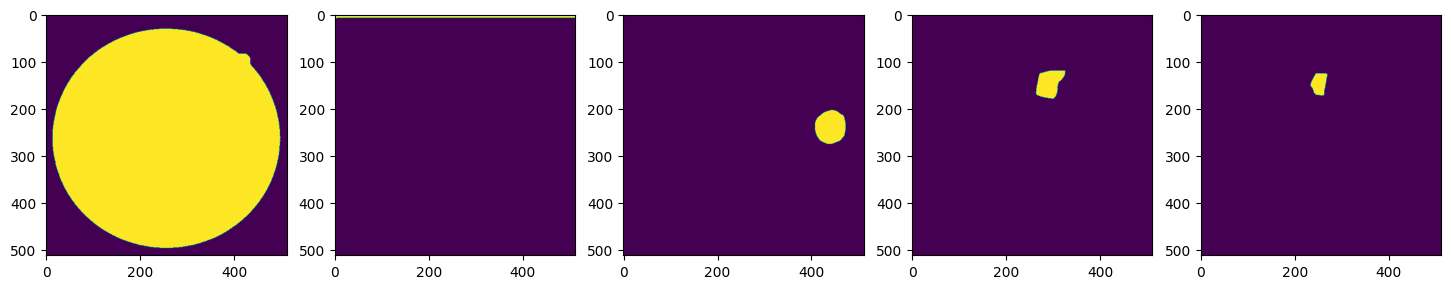

Mask 1:
 dice: 0.22613079845905304
 iou: 0.12747885286808014
 acc: 0.40987396240234375
 sensitivity: 0.9989392757415771
 specificity: 0.35422807931900024


Mask 2:
 dice: 0.0
 iou: 0.0
 acc: 0.8980484008789062
 sensitivity: 0.0
 specificity: 0.9828822612762451


Mask 3:
 dice: 0.07927176356315613
 iou: 0.04127172380685806
 acc: 0.9073982238769531
 sensitivity: 0.046185802668333054
 specificity: 0.9887524247169495


Mask 4:
 dice: 0.005224825814366341
 iou: 0.002619255566969514
 acc: 0.9041290283203125
 sensitivity: 0.002916998229920864
 specificity: 0.9892617464065552


Mask 5:
 dice: 0.012816216796636581
 iou: 0.0064494372345507145
 acc: 0.9100875854492188
 sensitivity: 0.0067621320486068726
 specificity: 0.995419979095459




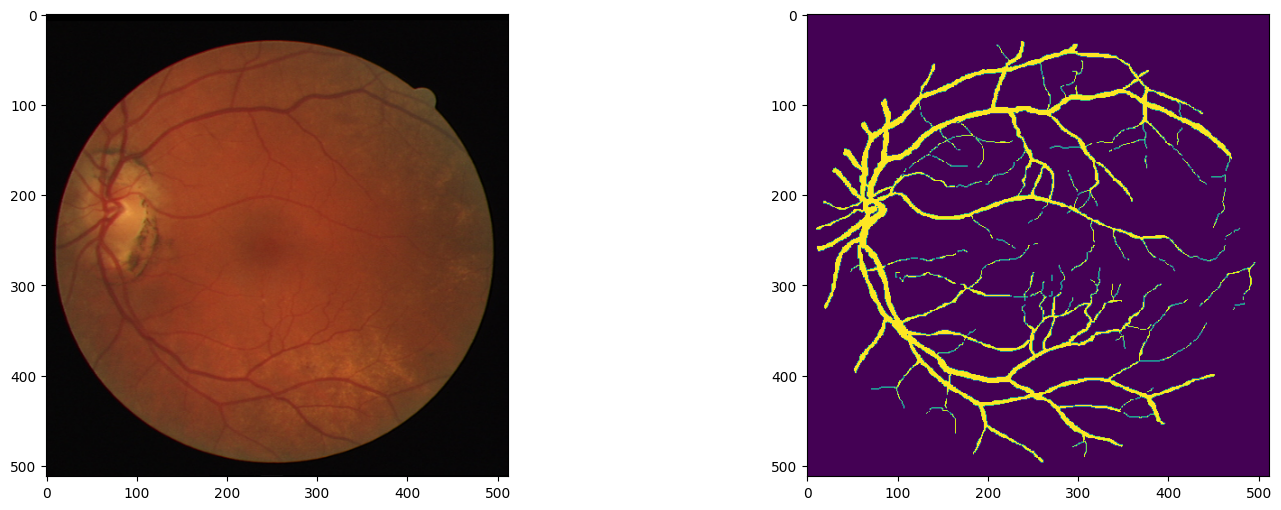

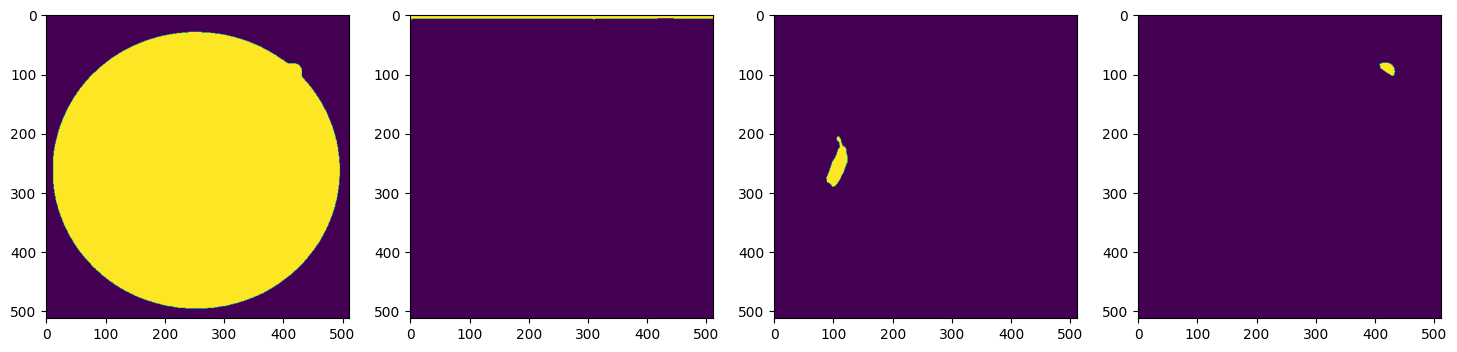

Mask 1:
 dice: 0.21778221428394318
 iou: 0.12219730764627457
 acc: 0.4056053161621094
 sensitivity: 0.993587076663971
 specificity: 0.35219067335128784


Mask 2:
 dice: 0.0
 iou: 0.0
 acc: 0.9011726379394531
 sensitivity: 0.0
 specificity: 0.9830387830734253


Mask 3:
 dice: 0.004122117534279823
 iou: 0.0020653156097978354
 acc: 0.9115257263183594
 sensitivity: 0.0021987082436680794
 specificity: 0.9941326379776001


Mask 4:
 dice: 0.0009910803055390716
 iou: 0.0004957858473062515
 acc: 0.9154052734375
 sensitivity: 0.0005038706585764885
 specificity: 0.9985185861587524




In [65]:
# im, lab = next(iter(test_loader_DRIVE))
for no, (im_batch, lab_batch) in enumerate(test_loader):

    for batch_no in range(len(im_batch)):
        im = np.swapaxes(np.swapaxes(im_batch[batch_no].numpy(force=True), 0, 2), 0, 1)
        im = (255 * im).astype(np.uint8)
        # print(im0.shape)
        # print(im0.dtype)
        # plt.imshow(im0)
        
        lab = lab_batch[batch_no].squeeze().numpy(force=True)
        # plt.imshow(lab0)
        # print(lab0.shape)
        # print(lab0.dtype)
        # print(np.max(lab))

        masks = mask_generator.generate(im)
        # print(len(masks))
        sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)

        fig, axs = plt.subplots(1,2)
        axs[0].imshow(im)
        axs[1].imshow(lab)
        plt.show()

        fig, axs = plt.subplots(1, min(5, len(sorted_masks)))
        for i, ax in enumerate(axs.flat):
            ax.imshow(sorted_masks[i]["segmentation"])
        plt.show()

        for i in range(min(5, len(sorted_masks))):
            print(f"Mask {i+1}:")
            evaluator.print_my_metrics(torch.from_numpy(sorted_masks[i]["segmentation"]), lab, '')
            print("\n")

        if batch_no >= 5:
            break
    break

## SAM predictor

In [66]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [67]:
model_type = "vit_h"
# device = "cuda"
sam = (sam_model_registry[model_type](checkpoint=sam_checkpoint)).to(device)
predictor = SamPredictor(sam)

In [68]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()

# def prepare_input(image, points, labels, boxes, sam):
#     rezise_transform = ResizeLongestSide(sam.image_encoder.img_size)
#     batched_input = [
#         {
#          'image': prepare_image(image, resize_transform, sam),
#          'points_coords': resize_transform.apply_coords_torch(points, image.shape[:2]),
#          'poinnt_labels': labels,
#          'boxes': resize_transform.apply_boxes_torch(boxes, image.shape[:2]),
#          'original_size': image.shape[:2]
#         }
#     ]

#     return batched_input

(1, 2)
(1,)


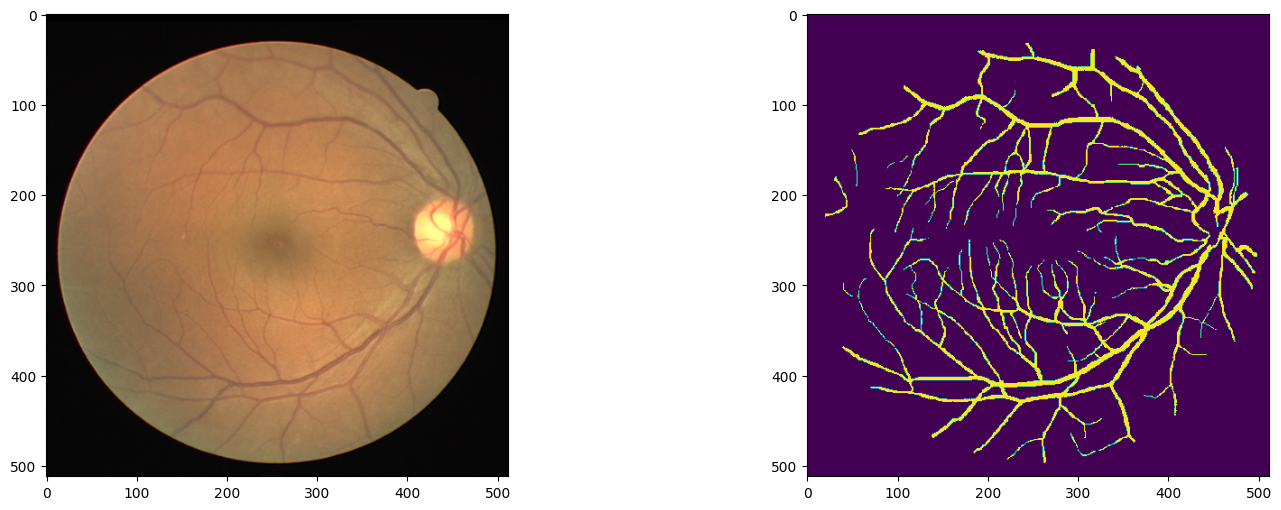

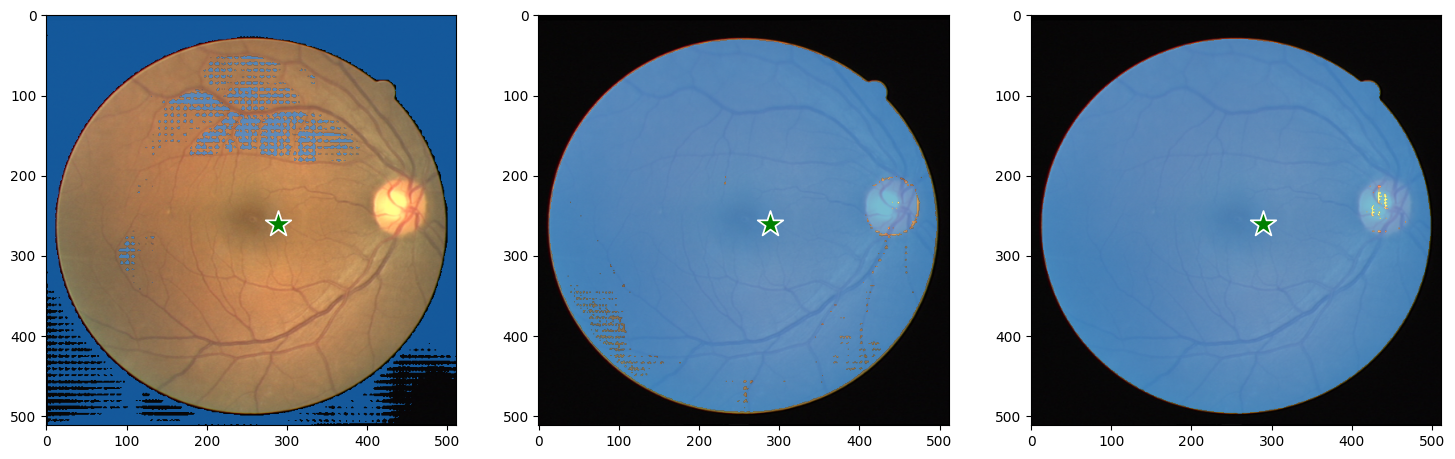

Mask 1:
 dice: 0.005111087113618851
 iou: 0.002562090987339616
 acc: 0.6168479919433594
 sensitivity: 0.011402810923755169
 specificity: 0.674041211605072


Mask 2:
 dice: 0.22591641545295715
 iou: 0.1273425966501236
 acc: 0.41790771484375
 sensitivity: 0.9841333031654358
 specificity: 0.3644193708896637


Mask 3:
 dice: 0.22562630474567413
 iou: 0.1271582841873169
 acc: 0.4091377258300781
 sensitivity: 0.9973039627075195
 specificity: 0.35357677936553955


(1, 2)
(1,)


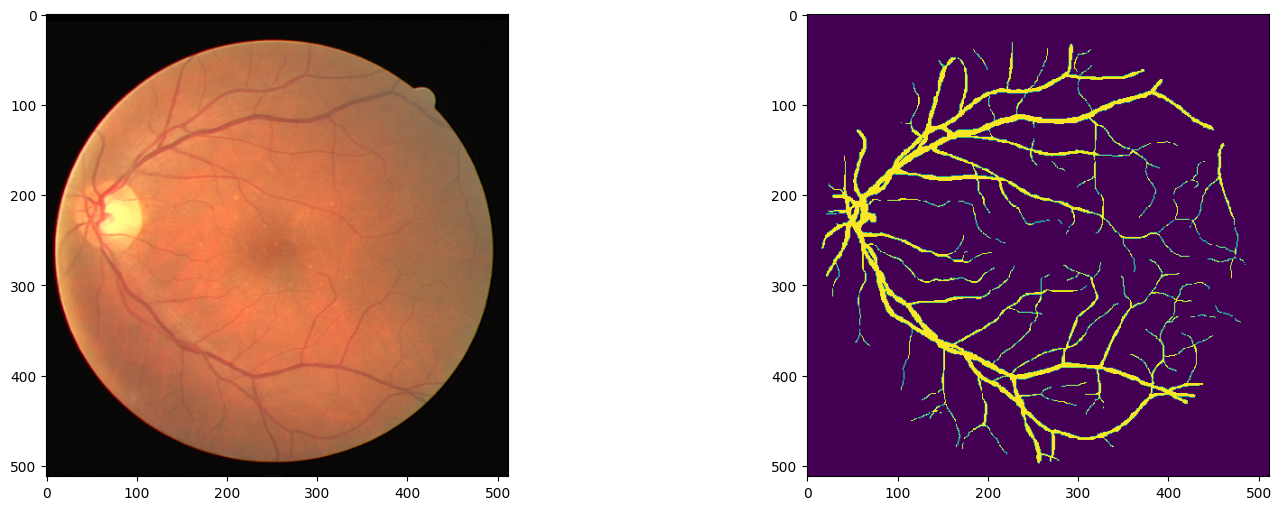

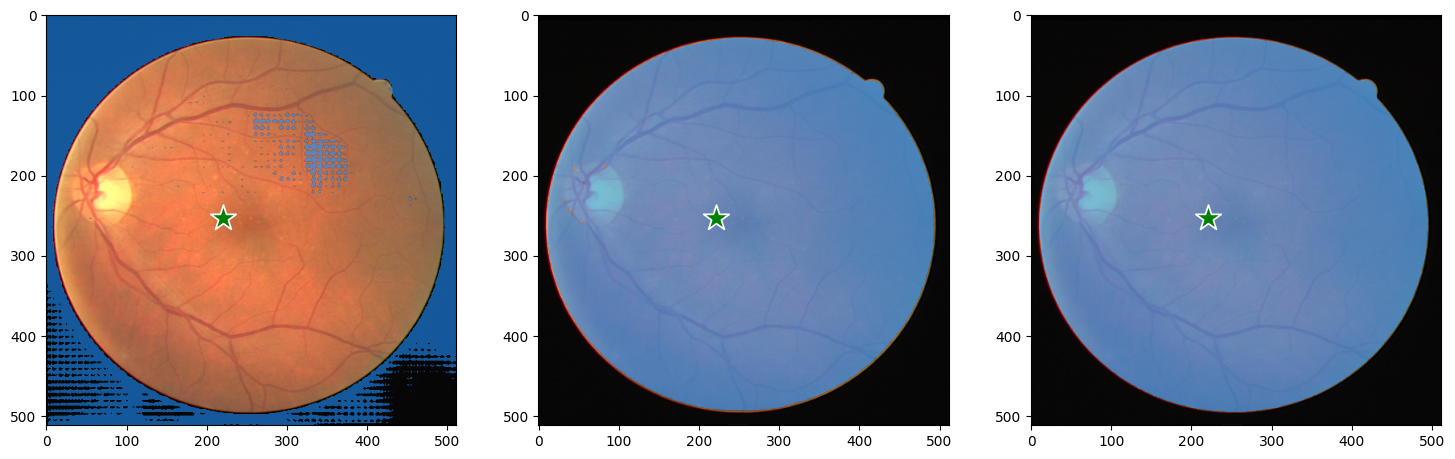

Mask 1:
 dice: 0.00039092617225833237
 iou: 0.00019550129945855588
 acc: 0.6488456726074219
 sensitivity: 0.0009177118190564215
 specificity: 0.7012451887130737


Mask 2:
 dice: 0.19926048815250397
 iou: 0.1106548085808754
 acc: 0.4019012451171875
 sensitivity: 0.9945957064628601
 specificity: 0.3539685904979706


Mask 3:
 dice: 0.19852784276008606
 iou: 0.11020311713218689
 acc: 0.3968963623046875
 sensitivity: 0.998317539691925
 specificity: 0.34825795888900757




In [69]:
for no, (im_batch, lab_batch) in enumerate(test_loader):

    for batch_no in range(len(im_batch)):
        im = np.swapaxes(np.swapaxes(im_batch[batch_no].numpy(force=True), 0, 2), 0, 1)
        im = (255 * im).astype(np.uint8)

        
        lab = lab_batch[batch_no].squeeze().detach().cpu().numpy(force=True)

        xs, ys = np.where(lab > 0.9)
        points = np.array([[y, x] for x,y in zip(xs, ys)])
        # print(len(points))
        nxs, nys = np.where(lab <= 0.5)
        n_points = np.array([[y, x] for x,y in zip(nxs, nys)])

        points = np.mean(points, axis=0).reshape(-1,2)
        n_points = []
        # points = points[np.random.choice(np.arange(len(points)), size=3, replace=False)].reshape(-1,2)
        # n_points = n_points[np.random.choice(np.arange(len(n_points)), size=1, replace=False)]
        # input_points = np.concatenate((points, n_points))
        input_points = points
        # input_points = points[13000:16000]
        # input_labels = np.array([1, 1, 1])
        input_labels = np.array([1]*input_points.shape[0])
        # input_labels = np.array([1]*len(points) + [0]*len(n_points))
        # input_labels = np.array([1])

        print(input_points.shape)
        print(input_labels.shape)

        input_box = np.array([400, 200, 460, 260])

        batch_input = [
            {
                'image': prepare_image(im, resize_transform, sam),
                'points_coords': resize_transform.apply_coords_torch(torch.from_numpy(input_points), im.shape[:2]),
                'point_labels': input_labels,
                # 'boxes': resize_transform.apply_boxes_torch(torch.from_numpy(input_box), im.shape[:2]),
                'original_size': im.shape[:2]
            }
        ]
        batched_output = sam(batch_input, multimask_output=True)

        # print(batched_output[0]['masks'].size())
        masks = batched_output[0]['masks'][0]
        # print(masks.shape)
        # print(masks[0].shape)

        # predictor.set_image(im)
        # masks, scores, logits = predictor.predict(
        #     point_coords=input_points,
        #     point_labels=input_labels,
        #     box = input_box[None, :],
        #     multimask_output=True
        # )

        # print(masks.shape)
        # fig, axs = plt.subplots(1,3)
        # axs[0].imshow(im)
        # axs[1].imshow(lab)
        # # axs[2].imshow(masks[0,:,:])
        # axs[2].imshow(im)
        # show_mask(masks, axs[2])
        # show_points(input_points, input_labels, axs[2])
        # show_box(input_box, axs[2])

        # plt.show()
        fig, axs = plt.subplots(1,2)
        axs[0].imshow(im)
        axs[1].imshow(lab)
        plt.show()

        fig, axs = plt.subplots(1, min(5, masks.shape[0]))
        for i, ax in enumerate(axs.flat):
            # ax.imshow(masks[i])
            ax.imshow(im)
            show_mask(masks[i].cpu().numpy(), ax)
            show_points(input_points, input_labels, ax)
            # show_box(input_box, ax)
        plt.show()

        for i, mask in enumerate(masks):
            print(f"Mask {i+1}:")
            evaluator.print_my_metrics(masks[i].cpu(), lab, '')
            print("\n")
        # masks = mask_generator.generate(im)
        # # print(len(masks))
        # sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)

        # fig, axs = plt.subplots(1,2)
        # axs[0].imshow(im)
        # axs[1].imshow(lab)
        # plt.show()

        # fig, axs = plt.subplots(1, min(5, len(sorted_masks)))
        # for i, ax in enumerate(axs.flat):
        #     ax.imshow(sorted_masks[i]["segmentation"])
        # plt.show()

        break
        
    if no >= 5:
        break